In [2]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
from sklearn.model_selection import train_test_split
import skimage.transform as sk_transform
import skimage.filters as sk_filters
from skimage.transform import SimilarityTransform
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
SVHN = h5py.File("SVHN_single_grey1.h5","r")

OSError: Unable to open file (unable to open file: name = 'SVHN_single_grey1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
X_train_val = SVHN["X_train"][:]
y_train_val = SVHN["y_train"][:]
X_test = SVHN["X_test"][:]
y_test = SVHN["y_test"][:]

In [4]:
SVHN.close()

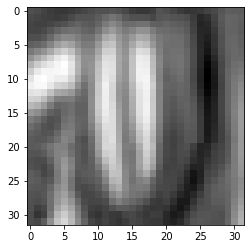

In [5]:
plt.imshow(X_train_val[25], cmap = "gray")

In [6]:
y_train_val[25]

0

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2)
print (X_train.shape)
print (y_train.shape)
print (X_val.shape)
print (y_val.shape)
print (X_test.shape)
print (y_test.shape)
train_dim = X_train.shape[0]
test_dim = X_test.shape[0]
val_dim = X_val.shape[0]

(33600, 32, 32)
(33600,)
(8400, 32, 32)
(8400,)
(18000, 32, 32)
(18000,)


In [8]:
class Linear():
    def __init__(self, in_, out_):
        self.W = np.random.randn(in_,out_) * 0.01
        self.b = np.zeros((1,out_))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradb = None
        self.gradInput = None
    
    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output
    
    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradb = np.sum(nextgrad, axis = 0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradb]

In [9]:
class Normalize():
    def __init__(self):
        self.params = []
        self.gradInput = None
    
    def forward(self, X):
        self.output = (X - np.mean(X))/(np.std(X)+0.0000001)
        return self.output
    
    def backward(self, nextgrad):
        return nextgrad, []

In [10]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None
    
    def forward(self, X):
        self.output = np.maximum(X,0)
        return self.output
    
    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput [self.output<=0] = 0 
        return self.gradInput, []

In [11]:
def softmax(X):
    exp_x = np.exp(X - np.max(X, axis = 1, keepdims = True))
    return exp_x/np.sum(exp_x, axis = 1, keepdims = True)

In [12]:
class CrossEntropy():
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m),y])
        loss = np.sum(cross_entropy) /self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()
        grad = softmax(X)
        grad[range(self.m),y] -= 1
        grad /=self.m
        return grad

In [13]:
class NN():
    def __init__(self, lossfunc = CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out, y)
        nextgrad = self.loss_func.backward(out, y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        return np.argmax(X, axis = 1)

    def predict_scores(self, X):
        X = self.forward(X)
        return X
    
    def clear_grad_param(self):
        self.grads = []

In [14]:
def update_params(velocity, params, grads, learning_rate = 0.01, mu = 0.9, epoch=1):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]

In [15]:
def minibatch (X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n, minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        X_batch = (X_batch - np.mean(X_batch))/(np.std(X_batch)+0.0000001)
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
    
    return minibatches

In [16]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu = 0.9, X_val=None, y_val = None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)    
    for i in range (epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate = learning_rate, mu = mu, epoch = epoch)
        
        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        
        y_train_pred = np.array([], dtype = "int64")
        y_val_pred = np.array([], dtype = "int64")
        y_train1 = []
        y_val1 = []        
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, :]
            y_tr = y_train[i:i + minibatch_size, ]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr) )
        
        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, :]
            y_va = y_val[i:i + minibatch_size, ]
            y_val1 = np.append(y_val1, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va) )
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_train1, y_train_pred)
        
        mean_train_loss = sum(loss_batch)/float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch)/float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print ("validation loss", mean_val_loss, " Validation Accuracy ", val_acc)
        #if mean_val_loss < np.min(val_loss_epoch):
         #   best_net = net.deepcopy()
    return net

In [17]:
def check_accuracy(y_true, y_pred):
    return (np.mean(y_true==y_pred))

In [18]:
X_train_flip = np.fliplr(X_train)
tform = SimilarityTransform(translation=(0, 2))
X_train_warp_up = []
j=0
for i in range(X_train.shape[0]):    
    X_train_warp_up.append(sk_transform.warp(X_train[i], tform))

In [19]:
tform = SimilarityTransform(translation=(0, -2))
X_train_warp_down = []
j=0
for i in range(X_train.shape[0]):    
    X_train_warp_down.append(sk_transform.warp(X_train[i], tform))

In [20]:
tform = SimilarityTransform(translation=(2, 0))
X_train_warp_left = []
j=0
for i in range(X_train.shape[0]):    
    X_train_warp_left.append(sk_transform.warp(X_train[i], tform))

In [21]:
tform = SimilarityTransform(translation=(-2, 0))
X_train_warp_right = []
j=0
for i in range(X_train.shape[0]):    
    X_train_warp_right.append(sk_transform.warp(X_train[i], tform))

In [22]:
X_train_warp_up = np.array(X_train_warp_up)
X_train_warp_right = np.array(X_train_warp_right)
X_train_warp_left = np.array(X_train_warp_left)
X_train_warp_down = np.array(X_train_warp_down)

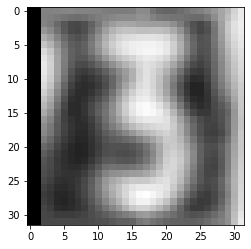

In [23]:
plt.imshow(X_train_warp_right[24].reshape(32,32), cmap = "gray")

In [24]:
X_train = X_train.reshape(train_dim,1024)
X_train_warp_right = X_train_warp_right.reshape(train_dim,1024)
X_train_warp_left = X_train_warp_left.reshape(train_dim,1024)
X_train_warp_up = X_train_warp_up.reshape(train_dim,1024)
X_train_warp_down = X_train_warp_down.reshape(train_dim,1024)
X_test = X_test.reshape(test_dim,1024)
X_val = X_val.reshape(val_dim,1024)
X_train = (X_train - np.mean(X_train))/(np.std(X_train)+0.0000001)
X_test = (X_test - np.mean(X_test))/(np.std(X_test)+0.0000001)
X_val = (X_val - np.mean(X_val))/(np.std(X_val)+0.0000001)

In [30]:
input_dim = X_train.shape[1]

iterations = 10
learning_rate = 0.1
hidden_nodes = 48
output_nodes = 10

nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(Normalize())
nn.add_layer(ReLU())
nn.add_layer(Normalize())
nn.add_layer(Linear(hidden_nodes, output_nodes))

random_value = np.random.randint(100)*0.01
nn = train(nn, X_train, y_train, minibatch_size=600, epoch = 20, learning_rate= learning_rate, X_val = X_val, y_val = y_val)
nn = train(nn, X_train+random_value, y_train, minibatch_size=600, epoch = 20, learning_rate= learning_rate, X_val = X_val, y_val = y_val)
nn = train(nn, X_train_warp_right, y_train, minibatch_size=600, epoch = 20, learning_rate= learning_rate, X_val = X_val, y_val = y_val)
nn = train(nn, X_train_warp_up, y_train, minibatch_size=600, epoch = 20, learning_rate= learning_rate, X_val = X_val, y_val = y_val)
nn = train(nn, X_train_warp_left, y_train, minibatch_size=600, epoch = 20, learning_rate= learning_rate, X_val = X_val, y_val = y_val)
nn = train(nn, X_train_warp_down, y_train, minibatch_size=600, epoch = 20, learning_rate= learning_rate, X_val = X_val, y_val = y_val)

validation loss 1.1696257330151756  Validation Accuracy  0.61625
validation loss 1.0349163189923192  Validation Accuracy  0.6788690476190476
validation loss 0.962369355681732  Validation Accuracy  0.7152678571428571
validation loss 0.9012315607991398  Validation Accuracy  0.7295833333333334
validation loss 0.8762709298747081  Validation Accuracy  0.7429464285714286
validation loss 0.8263990063302143  Validation Accuracy  0.7582440476190476
validation loss 0.8220505364896661  Validation Accuracy  0.7626785714285714
validation loss 0.7982625578230851  Validation Accuracy  0.773125
validation loss 0.7945331781076649  Validation Accuracy  0.7767857142857143
validation loss 0.7668182086118847  Validation Accuracy  0.7861309523809524
validation loss 0.7510635876933484  Validation Accuracy  0.794047619047619
validation loss 0.7382926888104973  Validation Accuracy  0.7974702380952381
validation loss 0.7332663834852882  Validation Accuracy  0.8033928571428571
validation loss 0.7358392177126014 

validation loss 0.6419801581132011  Validation Accuracy  0.7858333333333334
validation loss 0.6383850849264218  Validation Accuracy  0.7840178571428571
validation loss 0.6358832894270058  Validation Accuracy  0.7882440476190476
validation loss 0.633541597169427  Validation Accuracy  0.7878869047619048
validation loss 0.6304171603475456  Validation Accuracy  0.7885416666666667
validation loss 0.6274566120890992  Validation Accuracy  0.7914583333333334
validation loss 0.6277502852978881  Validation Accuracy  0.7912797619047619
validation loss 0.6268288073442206  Validation Accuracy  0.793422619047619
validation loss 0.6264907299690774  Validation Accuracy  0.7918452380952381
validation loss 0.6254873452079065  Validation Accuracy  0.7916369047619047
validation loss 0.6254471175646756  Validation Accuracy  0.7885119047619048


In [31]:
y_pred = nn.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1814
           1       0.75      0.76      0.76      1828
           2       0.72      0.81      0.76      1803
           3       0.57      0.73      0.64      1719
           4       0.81      0.80      0.80      1812
           5       0.78      0.75      0.76      1768
           6       0.79      0.67      0.73      1832
           7       0.89      0.77      0.83      1808
           8       0.72      0.72      0.72      1812
           9       0.71      0.75      0.73      1804

    accuracy                           0.75     18000
   macro avg       0.76      0.75      0.75     18000
weighted avg       0.76      0.75      0.75     18000



In [1]:
y_train1 = tensorflow.keras.utils.to_categorically(y_train, num_classes = 10)
y_test1 = tensorflow.keras.utils.to_categorically(y_test, num_classes = 10)
y_val1 = tensorflow.keras.utils.to_categorically(y_val, num_classes = 10)

NameError: name 'tensorflow' is not defined